# ***PS3***

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random as rand
from PIL import Image
from scipy.ndimage import rotate
import math

In [2]:
# grab the data
filepaths = {
    "x_train": "./trainX.txt",
    "y_train": "./trainY.txt",
    "x_test": "./testX.txt",
    "y_test": "./testY.txt"
}
x_train = pd.read_csv(filepaths["x_train"])
y_train = pd.read_csv(filepaths["y_train"])
x_test = pd.read_csv(filepaths["x_test"])
y_test = pd.read_csv(filepaths["y_test"])

print(x_train.shape)

(470, 784)


(784,)
(28, 28)


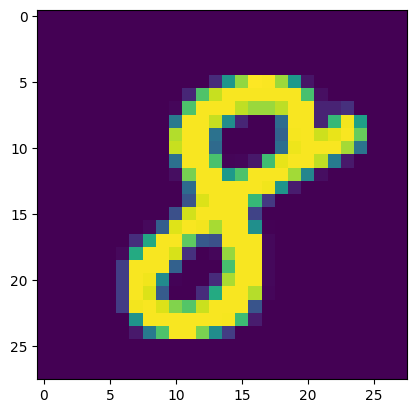

In [3]:
test = x_train.iloc[300, :].to_numpy()
test2 = test.reshape(28, 28)
print(test.shape)
print(test2.shape)
plt.imshow(test2)

## 1) **Bayesian Logistic Regression for Image Classification**

In [98]:
# create bayesian logistic regression class object
class BayesianLogisticRegression:

  # member variables
  sigma = 1

  # constructor
  def __init__(self, sigma = 1):
    self.sigma = sigma
    self.beta = []

  # fitting
  def fit(self, X, Y, params = {"epsilon": 10, "learning_rate": .01}):
    # add bias to X data
    X_bias = np.hstack((np.ones(shape = (X.shape[0], 1)), X))
    X_bias_shape = X_bias.shape

    # randomly initialize beta
    self.beta = np.random.normal(0, self.sigma, size = (X_bias_shape[1], 1))

    likelihood_grad_norm = 100

    # calculate the gradient
    while likelihood_grad_norm > params["epsilon"]:

      likelihood_grad_norm = 0
      for beta_idx in range(self.beta.shape[0]): # loop through all betas
        # lin_comb = np.exp(-X_bias @ self.beta)
        # likelihood_grad = (Y - np.ones(shape = Y.shape)) + (lin_comb / (np.ones(shape = lin_comb.shape) + lin_comb))
        # likelihood_grad = np.sum(likelihood_grad * X_bias[:, beta_idx]) + (likelihood_grad.shape[0] * (np.linalg.norm(self.beta)/self.sigma**2))
        likelihood_grad = self.beta_val(X_bias, Y, beta_idx)
        print(likelihood_grad)

        self.beta[beta_idx] += params["learning_rate"] * likelihood_grad

        likelihood_grad_norm += likelihood_grad ** 2 # for the condition

      likelihood_grad_norm = math.sqrt(likelihood_grad_norm)
      print(likelihood_grad_norm)

  # calculate individual beta value
  def beta_val(self, X, Y, beta_idx):

    m = X.shape[0]
    grad = 0

    for idx in range(m):
      lin_comb = np.exp(-X[idx, :] @ self.beta)

      grad += (Y[idx] - 1) * X[idx, beta_idx] + (lin_comb / (1 + lin_comb) * X[idx, beta_idx] + (np.linalg.norm(self.beta)/self.sigma ** 2))

    return grad / m


  # loss function
  def loss(self, y_pred, y_true):

    # calculate loss
    m = y_pred.shape[0]
    num_correct = m - np.sum(abs(y_pred - y_true))

    return num_correct / m

  # prediction
  def predict(self, X):

    pred = 1 / (1 + np.exp(-X @ self.beta))

    return pred


In [99]:
# extract only 1's and 0's
def extract_certain_values(X, Y, values):
  X = X.to_numpy()
  Y = Y.to_numpy()

  X_output = []
  Y_output = []

  for idx in range(X.shape[0]):
    if Y[idx] in values:
      X_output.append(X[idx, :])
      Y_output.append(Y[idx])

  return np.array(X_output), np.array(Y_output)

In [100]:
x_output, y_output = extract_certain_values(x_train, y_train, values = [0, 1])

In [101]:
bayesian_model = BayesianLogisticRegression(sigma = 1)

bayesian_model.fit(x_output, y_output)

# # simple x and beta for testing
# toy_x = np.array([[0, 1, 2], [3, 4, 5]])
# toy_beta = np.array([1, 2, 3])
# toy_beta = toy_beta.reshape(-1, 1)

# print(bayesian_model.pred(X = toy_x, beta = toy_beta))

[28.35091653]
[28.36006836]
[28.36443922]
[28.3798071]
[28.38589262]
[28.39298217]
[28.39756231]
[28.39513962]
[28.38762852]
[28.37873887]
[28.3761791]
[28.38101382]
[28.37724894]
[28.37304715]
[28.37018266]
[28.36707879]
[28.37231148]
[28.38130739]
[28.38768541]
[28.39587839]
[28.39863022]
[28.40448128]
[28.37851505]
[28.38990371]
[28.39588985]
[28.40270978]
[28.40981884]
[28.41586115]
[28.41184201]
[28.41954111]
[28.40767885]
[28.39846256]
[28.41265616]
[28.42910071]
[28.42523542]
[28.43015856]
[28.43498291]
[28.4236903]
[28.42521197]
[28.42950155]
[28.44023339]
[28.44582035]
[28.45563873]
[28.4727818]
[28.4605205]
[28.48220927]
[28.49585465]
[28.49502632]
[28.48462116]
[28.50882985]
[28.51595373]
[28.50069751]
[28.50197134]
[28.49407017]
[28.48754602]
[28.49551362]
[28.49125048]
[28.48299873]
[28.48046626]
[28.48718163]
[28.48702265]
[28.48982423]
[28.4961101]
[28.48627981]
[28.47119178]
[28.47123899]
[28.45106853]
[28.45123262]
[28.45416214]
[28.43433742]
[28.42453515]
[28.43284523

<ipython-input-98-f7c0301856c1>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  likelihood_grad_norm = math.sqrt(likelihood_grad_norm)


Streaming output truncated to the last 5000 lines.
[34.03343538]
[34.01895499]
[34.00681039]
[33.97220364]
[33.9822415]
[34.02544115]
[34.10669547]
[34.20750388]
[34.27915586]
[34.3157193]
[34.31249557]
[34.31905807]
[34.32541544]
[34.33261478]
[34.34903126]
[34.3666165]
[34.36162449]
[34.35950838]
[34.3630072]
[34.34628778]
[34.31442156]
[34.22947355]
[34.13277458]
[34.1012757]
[34.09102067]
[34.11643072]
[34.22582129]
[34.34300683]
[34.34784363]
[34.32213723]
[34.26726267]
[34.20713814]
[34.20585062]
[34.24663489]
[34.33342747]
[34.47030477]
[34.54549714]
[34.56363488]
[34.57953892]
[34.5805582]
[34.56948563]
[34.56619621]
[34.56923395]
[34.57739151]
[34.56859959]
[34.54758304]
[34.53697847]
[34.50268282]
[34.44711462]
[34.30920312]
[34.22276029]
[34.20330467]
[34.24702357]
[34.33411421]
[34.49957177]
[34.58808065]
[34.58500662]
[34.57057407]
[34.52207014]
[34.42817028]
[34.38781132]
[34.38096313]
[34.49100072]
[34.62969862]
[34.70661441]
[34.7333469]
[34.73288939]
[34.73356086]
[34.

KeyboardInterrupt: 

## 2) **PCA**

In [ ]:
# pca projection function for a given number of components
def pca_projection(dataset_x, components):
  pca = PCA(n_components = components)

  return pca.fit_transform(X = dataset_x)

# resulting projections
pca_projections_dict = {
    "10_pc": pca_projection(x_train, 10),
    "20_pc": pca_projection(x_train, 20),
    "30_pc": pca_projection(x_train, 30)
}

## 3) **Augmentation**

In [ ]:
# function that augments the image
param = {
    "degree_min": -15,
    "degree_max": 15,
    "translate_min": -5,
    "translate_max": 5
}


# function that augments the image
def augment_image(images, labels, param):
  random_degree = rand.randrange(param["degree_min"], param["degree_max"] + 1)
  translation_x = rand.randrange(param["translate_min"], param["translate_max"] + 1)
  translation_y = rand.randrange(param["translate_min"], param["translate_max"] + 1)

  dataframe_shape = images.shape
  images_copy = images.copy()
  labels_copy = labels.copy()

  # loop through each image and augment it
  for idx in range(dataframe_shape[0]):
    # rotate and then translate
    img_np_array = images.iloc[idx, :].to_numpy().reshape(28, 28)
    rotated_img = rotate(img_np_array, random_degree)
    translate_img = np.roll(img_np_array, translation_x, axis = 1)
    transformed_img = np.roll(translate_img, translation_y, axis = 0)

    images_copy = images_copy._append(pd.Series(transformed_img.reshape(-1)))


# testing
  # print(random_degree)
  # plt.imshow(rotate(images.iloc[300, :].to_numpy().reshape(28, 28), 0))
  # plt.imshow(np.roll(images.iloc[300, :].to_numpy().reshape(28, 28), 5, axis = 0))


augment_image(x_train, y_train, param)


## **Sources**
scikit-learn.org

https://stackoverflow.com/questions/53171057/numpy-matrix-rotation-for-any-degrees

https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.rotate.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html


